This project aims to answer to the following questions:
- What attributes contribute the most for a telephone selling call to be successful (that is, to lead the client subscribe a term deposit)?
- What is the profile of the most subscribing clients?

In [35]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from time import strptime
from datetime import datetime

In [2]:
DATA_PATH = "../data/"

In [3]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Importing data

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank-additional-full.csv"), sep=";")

In [5]:
df.shape

(41188, 22)

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,year,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,2008,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,2008,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
2,37,services,married,high.school,no,yes,no,telephone,may,2008,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,2008,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
4,56,services,married,high.school,no,no,yes,telephone,may,2008,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no


## 2. Analysis against the target

* Target

Is it balanced or unbalenced?

<AxesSubplot:xlabel='y', ylabel='count'>

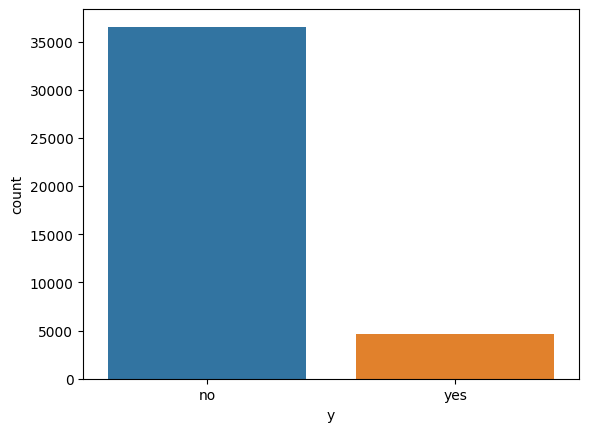

In [7]:
sns.countplot(data=df, x="y")

In [8]:
df["y"].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [9]:
len(df[df["y"] == "yes"]) / len(df)

0.11265417111780131

We see that the target has some imbalancement, where the positive target represents 11% of the dataset.

* Time relationship

According to the UCI Repository page, the dataset is ordered by date from May 2008 to November 2010 (roughly 2 years and 6 months = 30 months).

I've added manually the field `year`, assuming that it is ordered by date.

First, we convert the `month` abbreviated string to the respective number.

In [17]:
df["month_nb"] = df["month"].apply(lambda x : strptime(x,'%b').tm_mon)

In [18]:
df[["month", "month_nb"]].drop_duplicates()

,month,month_nb
0,may,5
7763,jun,6
12137,jul,7
18822,aug,8
23997,oct,10
24064,nov,11
27680,dec,12
27690,mar,3
27972,apr,4
37887,sep,9


Second, let's join the year and the month

In [22]:
df["anomes"] = (df["year"].astype(str) + df["month_nb"].astype(str).str.zfill(2)).astype(int)

How many of each reference do we have on the dataset? Are there missing references?

In [27]:
df["anomes"].value_counts().sort_index()

200805    7763
200806    4374
200807    6685
200808    5175
200810      67
200811    3616
200812      10
200903     282
200904    2458
200905    5794
200906     715
200907     178
200908     770
200909     267
200910     447
200911     357
200912     172
201003     264
201004     174
201005     212
201006     229
201007     311
201008     233
201009     303
201010     204
201011     128
Name: anomes, dtype: int64

Conclusions:
1. We can see that the biggest quantity of records are found in the year 2008.
2. We didn't have any call for the months 200809, 200901, 200902, 201001, 201002.
3. We had very few records in 200810, 200812.

In [10]:
sns.barplot(data=yes_distribution, x="index", y="counts")

NameError: name 'yes_distribution' is not defined

What is the proportion of positive and negative examples in each anomes?

In [29]:
df.groupby(["anomes"]).apply(lambda x : len(x[x["y"] == "yes"]) / len(x)).sort_index()

anomes
200805   0.031
200806   0.043
200807   0.061
200808   0.052
200810   0.627
200811   0.053
200812   0.100
200903   0.447
200904   0.180
200905   0.090
200906   0.369
200907   0.371
200908   0.343
200909   0.397
200910   0.403
200911   0.471
200912   0.512
201003   0.568
201004   0.557
201005   0.575
201006   0.467
201007   0.566
201008   0.515
201009   0.495
201010   0.456
201011   0.453
dtype: float64

We see and increasing proportion, that is, we have more positive examples among the years with less examples.

In [50]:
df_aux = df.copy()
df_aux["data"] = df_aux["anomes"].apply(lambda x : datetime.strptime(str(x), '%Y%m'))

In [51]:
df_aux[["anomes", "data"]].head()

,anomes,data
0,200805,2008-05-01
1,200805,2008-05-01
2,200805,2008-05-01
3,200805,2008-05-01
4,200805,2008-05-01


In [52]:
df_aux = df_aux.groupby(["data"])["y"].value_counts().rename("counts").to_frame().reset_index()

In [60]:
df_plot = pd.pivot_table(df_aux, values="counts", index="data", columns="y")
df_plot = df_plot.reset_index()
df_plot.head()

y,data,no,yes
0,2008-05-01,7523,240
1,2008-06-01,4186,188
2,2008-07-01,6278,407
3,2008-08-01,4904,271
4,2008-10-01,25,42


<AxesSubplot:xlabel='data'>

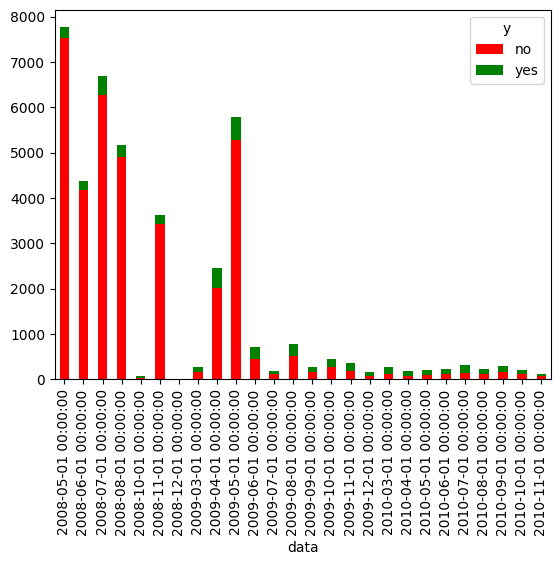

In [61]:
df_plot.plot(kind='bar', x="data", stacked=True, color=['red', 'green'])

* Age

Is there any tendency in age related to subscribe or not to a term deposit?

In [18]:
df.groupby("y")["age"].mean()

y
no    39.911
yes   40.913
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

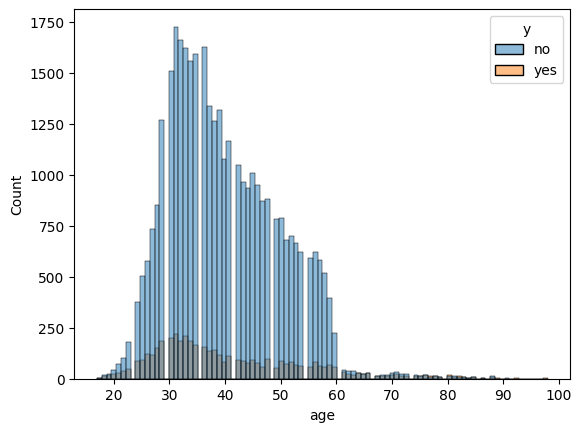

In [17]:
sns.histplot(data=df, x="age", hue="y")

It seams not to have any tendency in subscribing according to the age